# Analyzing Naturalistic Stimuli

In traditional list-learning free recall experiments, remembering is often cast as a binary operation: either an item is recalled or it isn't. This allows for a straight forward matching between the presented and recalled stimuli. However, characterizing and evaluating memory in more realistic contexts (e.g., telling a story to a friend about a recent vacation) is much more nuanced. Real-world recall is continuous, rather than binary. Further, the specific words used to describe an experience may vary considerably across participants. To handle this new data regime, we extended classic methods developed for free-recall list-learning experiments to accomodate naturalistic stimuli. Specifically, we provide a more flexible 'matching function', which quantifies the similarity between stimuli and verbal responses in a continuous manner.

In the tutorial below, we will describe our new analysis approach and demonstrate how to perform the analyses using `quail`. To get started, let's load in the example data:

In [9]:
import quail
%matplotlib inline
egg = quail.load_example_data(dataset='naturalistic')

The example data used in this tutorial is based on an open dataset from Chen et al., 2017, in which 17 participants viewed and then verbally recounted an episode of the BBC series _Sherlock_. We fit a topic model to hand-annotated text descriptions of the episode and used the model to transform the video annotations and the recall transcriptions for each subject. We then used a Hidden Markov Model to segment the video and recall models into an (optimal) number of events. The result was a matrix of topic vectors representing the "events" in the video and list of matrices of topic vectors representing participant's recall "events". We created an `egg` from these vector representations of the stimulus and verbal recall,  where the topic vectors were passed to quail as a stimulus features. Let's take a closer look at the egg:

In [11]:
egg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 34
Date created: Wed Aug  8 11:52:41 2018
Meta data: {}


Here, the egg's `pres` field consists of 34 stimulus events (the number of video segments determined by our HMM). Each stimulus event is represented by a dictionary containing the label of the video segment (`item`) and a topic vector representing that event (`features`). __NOTE: let's change `features` -> `topics` in the `egg`__

In [10]:
# The label of each stimulus event...
egg.get_pres_items().head()

,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
1,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
2,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
3,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
4,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33


In [5]:
# ...and their corresponding topic vectors
egg.get_pres_features().head()

,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770254e-05, 1.120407...","{'features': [1.1367721441462295e-05, 1.136772...","{'features': [1.0987763886778575e-05, 1.098776...","{'features': [1.0659164036611576e-05, 1.065916...","{'features': [1.8863247709037007e-05, 1.886324...","{'features': [0.0001067916639972405, 0.0001067..."
1,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770254e-05, 1.120407...","{'features': [1.1367721441462295e-05, 1.136772...","{'features': [1.0987763886778575e-05, 1.098776...","{'features': [1.0659164036611576e-05, 1.065916...","{'features': [1.8863247709037007e-05, 1.886324...","{'features': [0.0001067916639972405, 0.0001067..."
2,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770254e-05, 1.120407...","{'features': [1.1367721441462295e-05, 1.136772...","{'features': [1.0987763886778575e-05, 1.098776...","{'features': [1.0659164036611576e-05, 1.065916...","{'features': [1.8863247709037007e-05, 1.886324...","{'features': [0.0001067916639972405, 0.0001067..."
3,0,"{'features': [1.3095040225638681e-05, 1.309504...","{'features': [1.1307998068474283e-05, 1.130799...","{'features': [9.693039650300355e-06, 9.6930396...","{'features': [9.913957255604304e-06, 9.9139572...","{'features': [1.0626906175571998e-05, 1.062690...","{'features': [1.0663216195539594e-05, 1.066321...","{'features': [1.0532922580253435e-05, 1.053292...","{'features': [1.022682519393662e-05, 1.0226825...","{'features': [9.815446687603108e-06, 9.8154466...","{'features': [9.707331800972813e-06, 9.7073318...",...,"{'features': [1.1240052636101565e-05, 1.124005...","{'features': [1.2320787734091317e-05, 1.232078...","{'features': [1.224700269751644e-05, 1.2247002...","{'features': [1.1916331700340415e-05, 1.191633...","{'features': [1.1204077693770

In [8]:
# a closer look at one of the dictionaries
egg.get_pres_features()[0][0][0]

{'features': array([1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 6.98128585e-02,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-

As you can see above, the dictionary contains a `features` key, which holds a 100D topic vector representing a stimulus event and also a `temporal` key, which describes the serial position of the stimulus.  The `rec` field contains the recall events for each subject, similarly represented by a label (`'item'`) and topic vectors it comprises (`'features'`).

In [6]:
# The temporal position of each recall event...
egg.get_rec_items().head()

,,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,3,4,5,6,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,2,3,4,5,6,7,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,2,3,4,5,6,7,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,1,2,3,4,5,6,7,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,1,2,3,4,5,6,7,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# ...and their corresponding topic vectors
egg.get_rec_features().head()

,,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,"{'features': [0.00019430992385381985, 0.000194...","{'features': [0.00017027929367231326, 0.000170...","{'features': [0.00017369078885231097, 0.000173...","{'features': [0.00019384831708918682, 0.000193...","{'features': [0.00021172689406944874, 0.000211...","{'features': [0.0001967417938833908, 0.0001967...","{'features': [0.00018739098716436903, 0.000187...","{'features': [0.0007029745321813258, 0.0007029...",{},{},...,{},{},{},{},{},{},{},{},{},{}
1,0,"{'features': [0.0001893882261801681, 0.0001893...","{'features': [0.000147870701282558, 0.00014787...","{'features': [0.00019023353033654396, 0.000190...","{'features': [0.00018166938444643692, 0.000181...","{'features': [0.0001625481095703973, 0.0001625...","{'features': [0.00017324045166665215, 0.000173...","{'features': [0.00020984959154624308, 0.000209...","{'features': [0.00021871502948704968, 0.000218...","{'features': [0.00023880652209349367, 0.000238...","{'features': [0.00020811361546785266, 0.000208...",...,{},{},{},{},{},{},{},{},{},{}
2,0,"{'features': [0.00018590937074552605, 0.000185...","{'features': [0.0002086223458447991, 0.0002086...","{'features': [0.00014376082951536893, 0.000143...","{'features': [0.00017953275349176222, 0.000179...","{'features': [0.0001266373016964342, 0.0001266...","{'features': [0.00012300799059941801, 0.000123...","{'features': [0.00012981062271781097, 0.000129...","{'features': [0.00013602953297943621, 0.000136...","{'features': [0.00014111281486418062, 0.000141...","{'features': [0.00012592147339385905, 0.000125...",...,{},{},{},{},{},{},{},{},{},{}
3,0,"{'features': [0.00018228403991448364, 0.000182...","{'features': [0.00018629081950116504, 0.000186...","{'features': [0.0001622345358076629, 0.0001622...","{'features': [0.00023810735183527187, 0.000238...","{'features': [0.0001552297878347715, 0.0001552...","{'features': [0.00016179442394432278, 0.000161...","{'features': [0.00016889623308560304, 0.000168...","{'features': [0.00019056297121315633, 0.000190...","{'features': [0.0005565476190479086, 0.0005565...",{},...,{},{},{},{},{},{},{},{},{},{}
4,0,"{'features': [0.00025446487845416085, 0.000254...","{'features': [0.00027871701312132265, 0.000278...","{'features': [0.00023918073796144946, 0.000239...","{'features': [0.00017315740792590048, 0.000173...","{'features': [0.0001356024754279286, 0.0001356...","{'features': [9.160956058842264e-05, 9.1609560...","{'features': [9.360224876174755e-05, 9.3602248...","{'features': [0.00013752072250850062, 0.000137...","{'features': [0.0001320162835250347, 0.0001320...","{'features': [0.00014302384767721986, 0.000143...",...,{},{},{},{},{},{},{},{},{},{}


# Defining a matching function

As summarized above, `quail` supports the analysis of naturalistic stimuli by providing a more flexible way to match presented stimuli and recall responses. The matching function can be set using the `match` keyword argument in `egg.analyze`. There are three options: `'exact'`, `'best'`, and `'smooth'`. If `match='exact'`, the recall item must be identical to the stimulus to constitute a recall. This is the traditional approach for free recall experiments (either a subject accurately recalled the stimulus item, or did not) but it is not particularly useful with naturalistic data. For the naturalistic options, quail computes a similarity matrix comparing every recall event to every stimulus event. If `match='best'`, the recall response that is most similar to a given presented stimulus is labeled..

In [6]:
import numpy as np
import seaborn as sns
from quail.analysis.recmat import recall_matrix

recall_matrix(egg, match='best', distance='correlation', features='features')
similarity_matrix = recall_matrix.simmtx

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)


Here is the similarity matrix for a single subject, with stimulus events along the x-axis and recall events on the y-axis. Color corresponds to the level of similarity between stimulus and recall events.

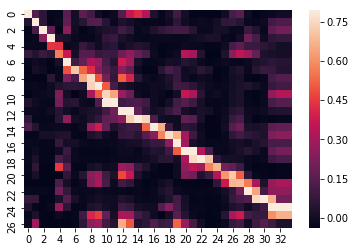

In [7]:
a_single_subject = similarity_matrix[12]
sns.heatmap(a_single_subject, robust=True)

## `best`

If `match='best'`, each recall event is then assigned to the single stimulus event whose feature vectors are most similar based on the `distance` kwarg (more on that later).

In [9]:
spc = egg.analyze(analysis='spc', match='best', distance='correlation', features='features')

# Here, each stimulus event is assigned a binary value for each recall event – it either was matched or it was not
spc.data.head()

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)


,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


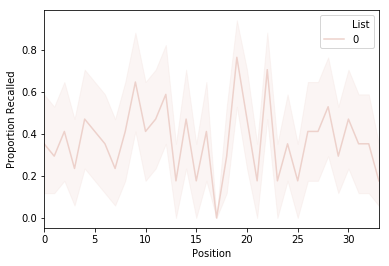

In [10]:
spc.plot()

## `smooth`

if `match='smooth'`, quail computes a weighted average across all stimulus events for each recall event, where the weights are derived from similarity between the stimulus and recall.

In [11]:
#@andy I think something's wrong here since chaning that line... there's a lot of NaNs. 
# Maybe somewhere a np.mean needs to be a np.nanmean?

spc = egg.analyze(analysis='spc', match='smooth', distance='correlation', features='features')

# Here, each stimulus event was assigned a value for every recall event based on the similarity of the two
spc.data.head()

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:93: RuntimeWarning: invalid value encountered in multiply
  res = np.empty((len(lists), len(features), recalled.iloc[0].shape[0], presented.iloc[0].shape[0]))*np.nan
/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)
/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/spc.py:48: RuntimeWarning: Mean of empty slice
  result = np.nanmean(recmat, 2)


,,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0.141093,0.091340,0.116522,0.090537,0.090405,0.120882,0.145042,0.116274,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.111568,0.102694,0.120036,0.148601,0.142244,0.133014,0.138000,0.126327,0.095996,0.116748,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.091751,0.088364,0.080881,0.102522,0.121927,0.116985,0.107489,0.117292,0.134370,0.124367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.071832,0.087288,0.097175,0.098785,0.123228,0.137107,0.120174,0.138510,0.115528,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.090525,0.074351,0.095836,0.084962,0.095560,0.146431,0.161078,0.117885,0.141311,0.134520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


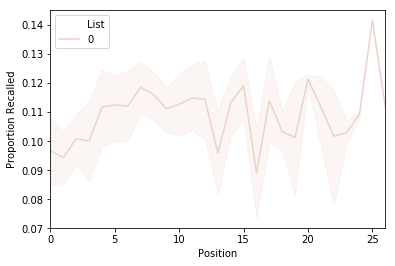

In [12]:
spc.plot()

# The `distance` key word argument

The `distance` kwarg assigns the distance formula quail will use to compute similarity between stimulus and recall events. The examples above used the correlation coefficient as a measure of similarity (`distance='correlation'`). Alternatively, `distance='euclidean'` (default) can be used to compute similarity based on Euclidean distance. 

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/spc.py:48: RuntimeWarning: Mean of empty slice
  result = np.nanmean(recmat, 2)
/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:93: RuntimeWarning: invalid value encountered in multiply
  res = np.empty((len(lists), len(features), recalled.iloc[0].shape[0], presented.iloc[0].shape[0]))*np.nan


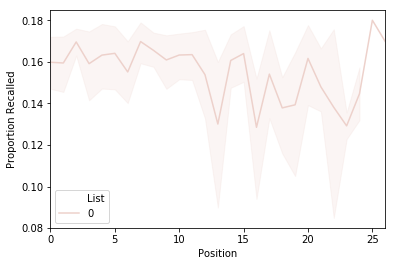

In [13]:
spc = egg.analyze(analysis='spc', match='smooth', distance='euclidean', features='features')
spc.plot()

## more options

Quail supports any similarity matric supported by `scipy.spatial.distance.cdist`. A complete list is available [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

As discussed in the Egg tutorial, custom distance functions can be added to `Egg` objects, both during and after instantiating. Once added, custom distance functions are stored in `egg.dist_funcs`. 

# The `features` key word argument

The `features` kwarg tells quail which features to consider when computing distance. This can be a single feature passed as a string, multiple features passed as a list, or all available features (`features=None`; default). 

In the above examples, we passed the `features` argument the array of topic vectors for each each stimulus and recall event (`features`). 
What if we hadn't?

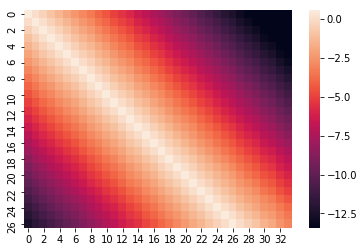

In [14]:
recall_matrix(egg, match='smooth', distance='euclidean')
similarity_matrix = recall_matrix.simmtx
similarity_across_subs = np.nanmean(similarity_matrix,axis=0)
sns.heatmap(similarity_across_subs, robust=True)

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/spc.py:48: RuntimeWarning: Mean of empty slice
  result = np.nanmean(recmat, 2)


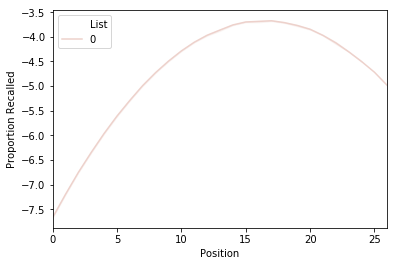

In [15]:
spc = egg.analyze(analysis='spc', match='smooth', distance='euclidean')
spc.plot()

This definitely doesn't look right...let's look at the contents of our feature dictionaries

In [16]:
egg.feature_names

['features', 'temporal']

There's another feature, `'temporal'` that contains the presentation position for the stimulus data and the recall position for the recall data. Since these are just indices of the events from 0 to n, they're perfectly related, and will confound our analyses!